## Objective and Outline

Main goal is to have some fun with the PPP dataset [located here](https://home.treasury.gov/policy-issues/cares-act/assistance-for-small-businesses/sba-paycheck-protection-program-loan-level-data).  Inspired by [this tweet](https://twitter.com/dataeditor/status/1280278987797942272) we'll look at city misspellings in the PPP data, starting with Philadelphia.  Specifically we'll look at calculating a histogram of the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) across all misspellings in the dataset.

Some features we hope to highlight:
- Prefect's dynamic mapping feature, and how this places nicely with Dask
- running Prefect Flows on dask with a `LocalCluster`


## The Data

- download the data
- look at it
- eyeball the Philadelphia mispellings

In [1]:
import pandas as pd

df = pd.read_csv("PPPData.csv")
df.head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
0,a $5-10 million,"ARCTIC SLOPE NATIVE ASSOCIATION, LTD.",7000 Uula St,BARROW,AK,99723.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,295.0,04/14/2020,"National Cooperative Bank, National Association",AK - 00
1,a $5-10 million,CRUZ CONSTRUCTION INC,7000 East Palmer Wasilla Hwy,PALMER,AK,99645.0,238190.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,215.0,04/15/2020,First National Bank Alaska,AK - 00
2,a $5-10 million,"I. C. E. SERVICES, INC",2606 C Street,ANCHORAGE,AK,99503.0,722310.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,367.0,04/11/2020,KeyBank National Association,AK - 00
3,a $5-10 million,KATMAI HEALTH SERVICES LLC,"11001 O'MALLEY CENTRE DRIVE, SUITE 204",ANCHORAGE,AK,99515.0,621111.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/29/2020,Truist Bank d/b/a Branch Banking & Trust Co,AK - 00
4,a $5-10 million,MATANUSKA TELEPHONE ASSOCIATION,1740 S. CHUGACH ST,PALMER,AK,99645.0,517311.0,Cooperative,Unanswered,Unanswered,Unanswered,NaN,267.0,06/10/2020,CoBank ACB,AK - 00


In [2]:
len(df.State.value_counts())

57

In [3]:
df[df['BusinessName'].str.lower().str.contains('yeez') == True]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
29024,b $2-5 million,YEEZY LLC,6 CENTERPOINTE DR #700,LA PALMA,CA,90623.0,448110.0,Limited Liability Company(LLC),Black or African American,Male Owned,Non-Veteran,NaN,106.0,04/13/2020,City National Bank,CA - 38


In [4]:
philly_mask = (df['City'].str.lower().str.startswith('phil') == True) & (df['State'] == 'PA')
df[philly_mask].City.value_counts()

PHILADELPHIA     2459
PHILA              23
PHILIPSBURG        16
PHILADELPHIA,       3
PHILADEPHIA         1
PHILADELPIA         1
PHILA.              1
PHILADELKPHIA       1
PHILDADELPHIA       1
PHILADELPHILA       1
PHILDELPHIA         1
Name: City, dtype: int64

In [5]:
df2 = pd.read_csv("PPPDataSmallLoan-PA.csv")

In [6]:
philly_mask2 = (df2['City'].str.lower().str.startswith('phil') == True) & (df2['State'] == 'PA')
df2[philly_mask2].City.value_counts()

PHILADELPHIA        13498
PHILA                 263
PHILIPSBURG            85
PHILADEPHIA            19
PHILADLEPHIA           19
PHILDELPHIA            15
PHILADELPIA             8
PHILADELPHIA,           6
PHILADELHIA             4
PHILADELPHA             4
PHILADLPHIA             4
PHILA.                  3
PHILLY                  2
PHILDADELPHIA           2
PHILADEPHILA            2
PHILADELLPHIA           2
PHILADELPHIA, PA        2
PHILADEPLHIA            2
PHILADELPHIAP           2
PHILLIPSBURG            2
PHILAELPHIA             2
PHILADELPHIA PA         2
PHILADELPHI             2
PHILLADELPHIA           2
PHILADELPHAI            2
PHILADELPPHIA           1
PHILADELPH              1
PHILADALPHIA            1
PHILDADLPHIA            1
PHILADELOHIA            1
PHILADEPHA              1
PHILADELPHIOA           1
PHILADELAPHIA           1
PHILIDELPHIA            1
PHILAD                  1
PHILLA                  1
PHILADEDLPHIA           1
PHILIADELPHIA           1
PHILADLELPHI

## Build a Prefect Flow for reproducibility + efficiency

Now we'll build a more programmatic set of tasks for downloading / processing our files.  Some Prefect features this is intended to highlight:
- Prefect "mapping"

We should walk through / build this incrementally live but here's the final product:

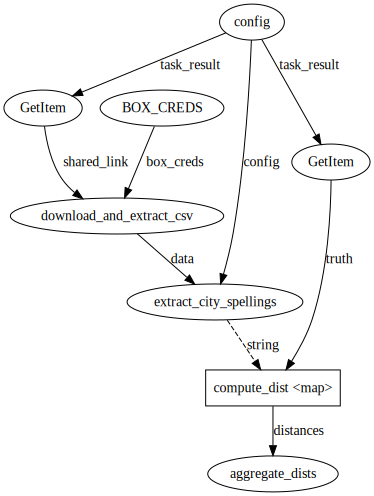

In [7]:
import collections
import datetime
import glob
import io
import os
import pandas as pd
import tempfile
import zipfile

from Levenshtein import distance

from prefect import task, Flow, Parameter, unmapped
from prefect.engine.results import S3Result
from prefect.tasks.secrets import PrefectSecret


config = Parameter("config", default=dict(prefix="phil", 
                                          city="Philadelphia")

@task
def get_PPP_dataframe():
    return pd.read_csv("PPPData.csv")
    

@task
def extract_city_spellings(config, data):
    """
    Given config w/ prefix and dataset, returns the unique
    set of cities beginning with that prefix.
    """
    prefix = config['prefix'].lower()
    mask = data['City'].str.lower().str.startswith(prefix) == True
    return list(set(data[mask].City.unique()))


@task
def compute_dist(string, truth):
    """
    Returns the Levenshtein distance between the two strings
    """
    return distance(string, truth)


@task
def aggregate_dists(distances):
    """
    Returns a 'histogram' of the counts
    """
    return collections.Counter(distances)


# compile our tasks into a Flow object
with Flow("PPP Coiled Demo") as flow:

    data = get_PPP_dataframe()
    spellings = extract_city_spellings(config, data)
    
    # more interesting dynamic fan out + reduce step
    distances = compute_dist.map(spellings, unmapped(config['city']))
    results = aggregate_dists(distances)

    
flow.visualize()

## Various ways of running the Flow

In [ ]:
# purely local sequential run
flow_state = flow.run()
flow_state.result[results].result # final tally

In [ ]:
# local dask run
from prefect.engine.executors import DaskExecutor

flow_state = flow.run(executor=DaskExecutor())
flow_state.result[results].result # final tally